## Dataset Au-Au: ponta de ouro e substrato de ouro
### Teste 18.1/19.1 - 2x2, `grid_eight`, 100 séries temporais.
Esse notebook tem um diferencial em relação aos anteriores: nele, foram feitos testes sequenciais ou recursivos, ou seja, testes nos quais são feitos uma clusterização inicial para separar os motifs que pegam a área de interesse de estudo da curva, seguido de uma outra clusterização para identificar diferentes padrões nessas curvas. Para isso, aplicamos uma rede com dimensão 2x2 em nossos dados, e utilizamos o melhor cluster para aplicar redes 2x2 ou 3x3 para agrupamentos dos motifs deste.
### Importando bibliotecas e dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

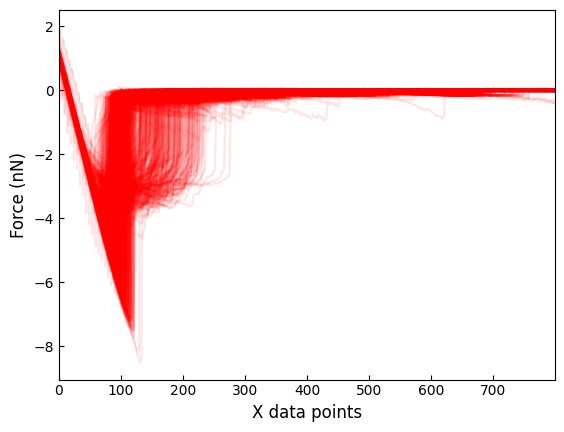

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Para essa clusterização, foram selecionados as **primeiras 100 curvas** do *dataset*.

In [8]:
train_set = force_data[:100]
test_set = force_data[100:]

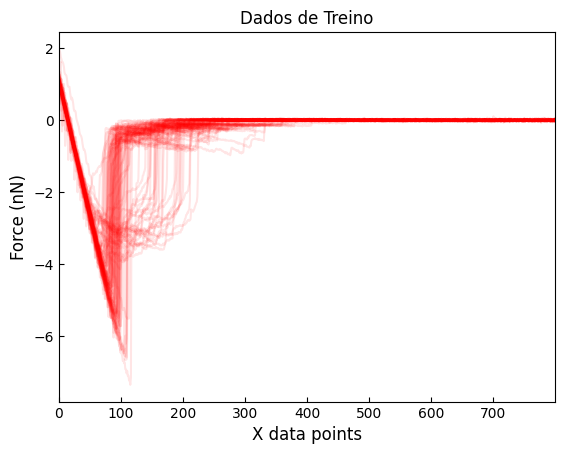

In [9]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
len(train_set[0])

800

### Concatenando os dados e descobrindo motifs
Todas as curvas foram concatenadas em uma única série temporal, como indicado no artigo de base, do desenvolvimento do método DTW-SOM.

In [13]:
size = len(train_set[0])
sample_size = len(train_set)
print(size, sample_size)

800 100


In [14]:
joined_data = train_set[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set[i]))
len(joined_data)

80000

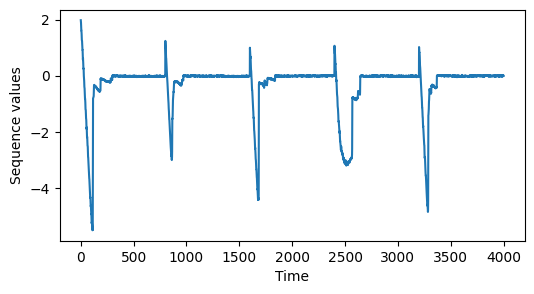

In [15]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [16]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 49.5 s, sys: 608 ms, total: 50.1 s
Wall time: 50.1 s


In [17]:
print(mp[1])

[23987. 23988. 23989. ... 51997. 51998. 51999.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

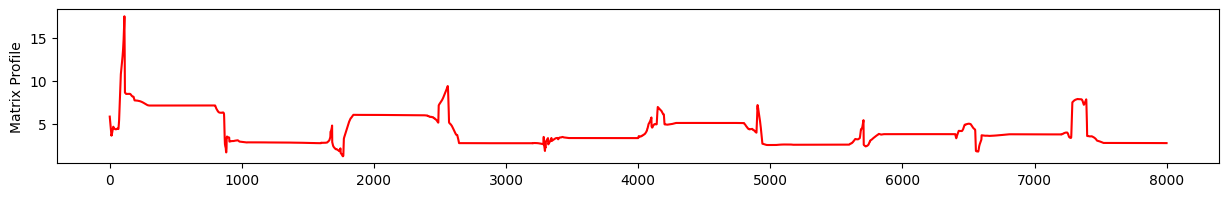

In [18]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [19]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 180 ms, sys: 64 ms, total: 244 ms
Wall time: 211 ms


38

Criando uma lista com os centros de motifs.

In [20]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

80000

In [21]:
len(motif_center_list)

38

### Treinando a rede DTW-SOM

In [22]:
%time
rows = 2
cols = 2
structure = type_conn.grid_eight
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [23]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 5.4843
Epoch 2 achieved an average quantization error of 10.9011
Epoch 3 achieved an average quantization error of 11.5559
Epoch 4 achieved an average quantization error of 11.3833
Epoch 5 achieved an average quantization error of 11.4073
Epoch 6 achieved an average quantization error of 11.3802
Epoch 7 achieved an average quantization error of 11.3507
Epoch 8 achieved an average quantization error of 11.2267
Epoch 9 achieved an average quantization error of 11.215
Epoch 10 achieved an average quantization error of 11.1653
Epoch 11 achieved an average quantization error of 11.0671
Epoch 12 achieved an average quantization error of 9.6324
Epoch 13 achieved an average quantization error of 8.5002
Epoch 14 achieved an average quantization error of 7.9504
Epoch 15 achieved an average quantization error of 7.5132
Epoch 16 achieved an average quantization error of 7.1285
Epoch 17 achieved an average quantization error of 6.9513
Epoch 18 achie

50

### Resultados

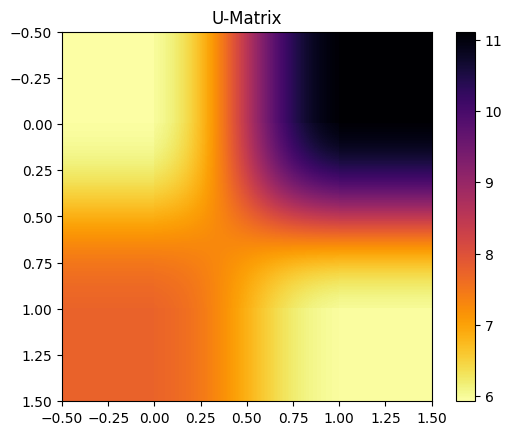

In [24]:
network.show_distance_matrix()

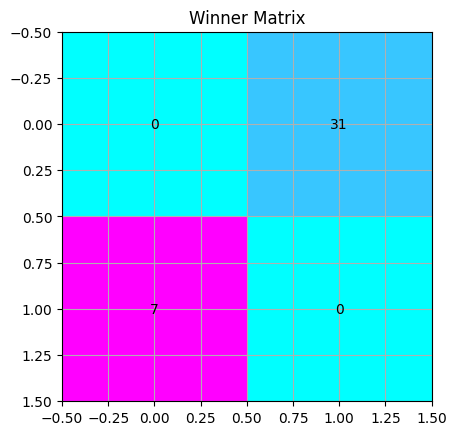

In [25]:
network.show_winner_matrix()

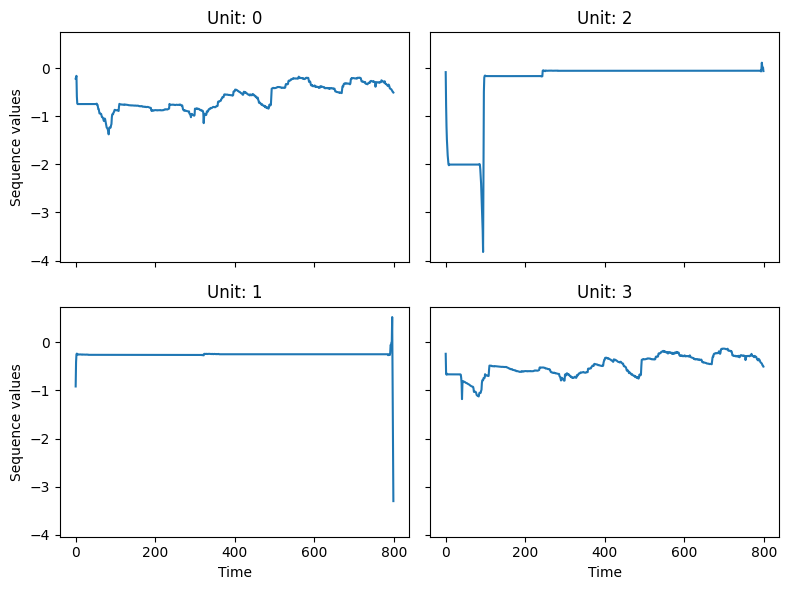

In [26]:
n_neurons = network._size
fig, axs = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

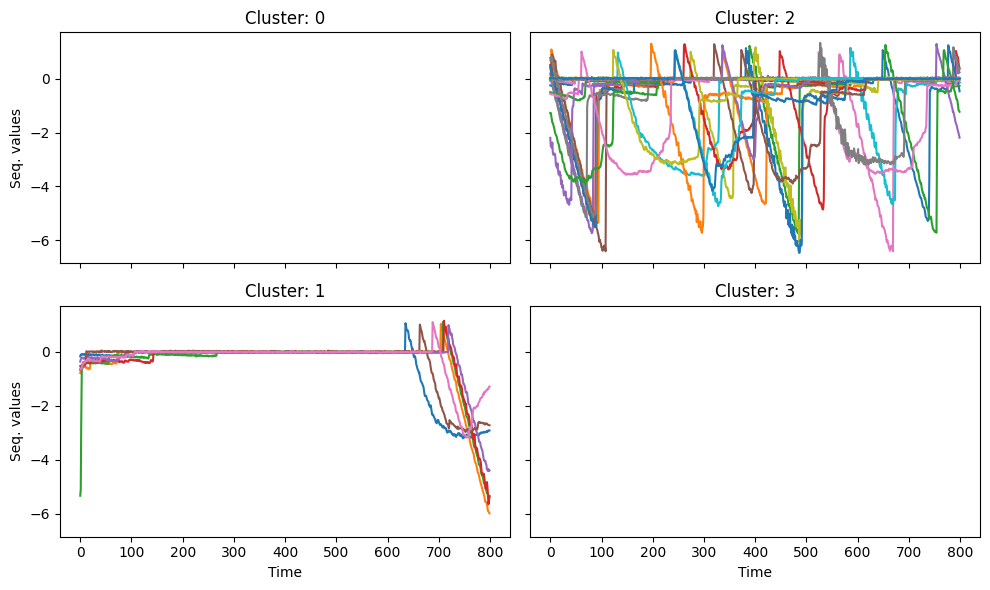

In [27]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

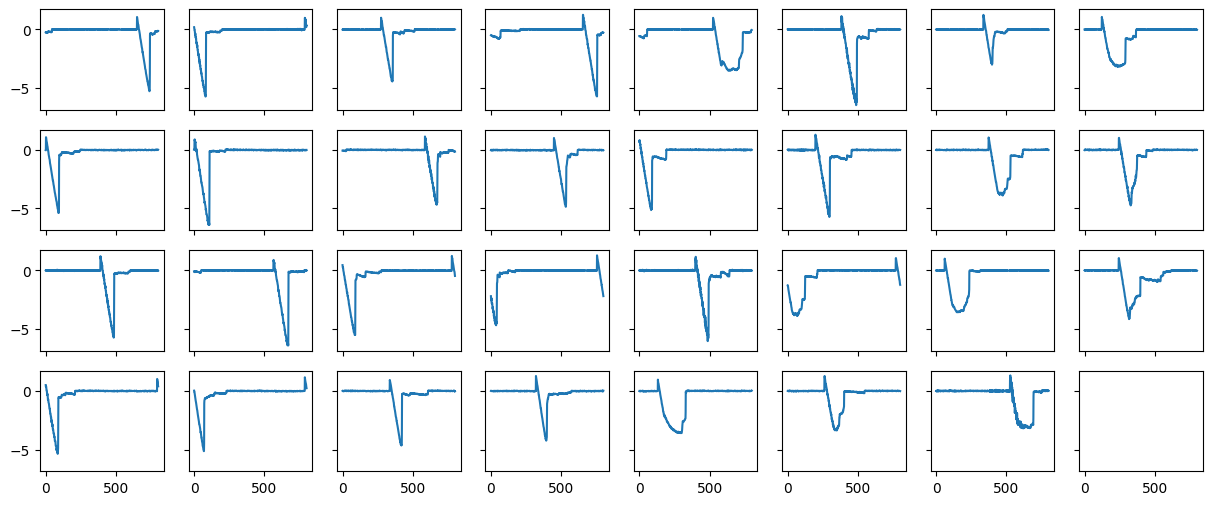

In [31]:
fig, axs = plt.subplots(4, 8,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

### Teste 18.2 - 3x3, `grid_eight`, motifs do cluster 2 do teste 18.1.

In [37]:
cluster2 = network.capture_objects[2]
cluster2

[1,
 5,
 6,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37]

In [ ]:
new_motifs = [mtfs[i] for i in cluster2]

In [43]:
motif_center_list2 = []
for motif in new_motifs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list2.append(motif_center)

In [46]:
len(motif_center_list2)

31

##### Treinando a nova rede neural

In [47]:
%time
rows2 = 3
cols2 = 3
structure = type_conn.grid_eight
network2 = dtwsom.DtwSom(rows2, cols2, structure)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [48]:
%%time
network2.train(motif_center_list2, 50)

Epoch 1 achieved an average quantization error of 2.8964
Epoch 2 achieved an average quantization error of 3.745
Epoch 3 achieved an average quantization error of 3.6561
Epoch 4 achieved an average quantization error of 4.0724
Epoch 5 achieved an average quantization error of 4.1361
Epoch 6 achieved an average quantization error of 3.8774
Epoch 7 achieved an average quantization error of 3.5679
Epoch 8 achieved an average quantization error of 3.5608
Epoch 9 achieved an average quantization error of 3.472
Epoch 10 achieved an average quantization error of 3.339
Epoch 11 achieved an average quantization error of 3.2807
Epoch 12 achieved an average quantization error of 3.2429
Epoch 13 achieved an average quantization error of 3.2102
Epoch 14 achieved an average quantization error of 3.1931
Epoch 15 achieved an average quantization error of 3.1923
Epoch 16 achieved an average quantization error of 3.1694
Epoch 17 achieved an average quantization error of 3.1568
Epoch 18 achieved an avera

50

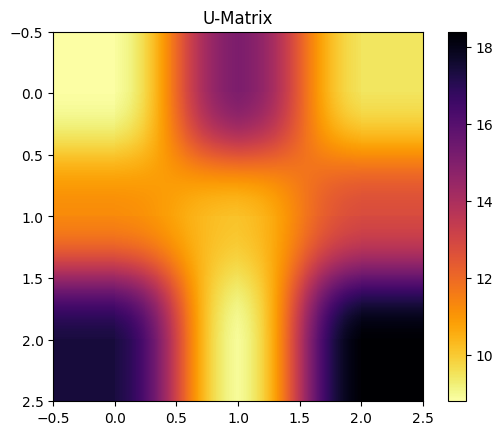

In [50]:
network2.show_distance_matrix()

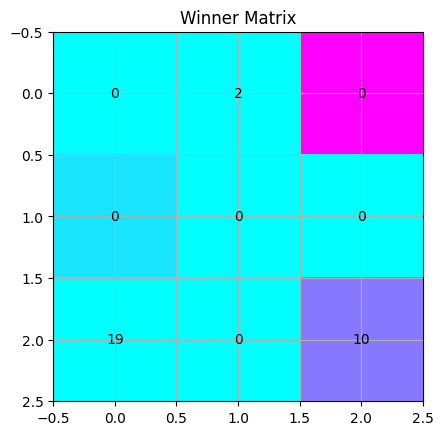

In [51]:
network2.show_winner_matrix()

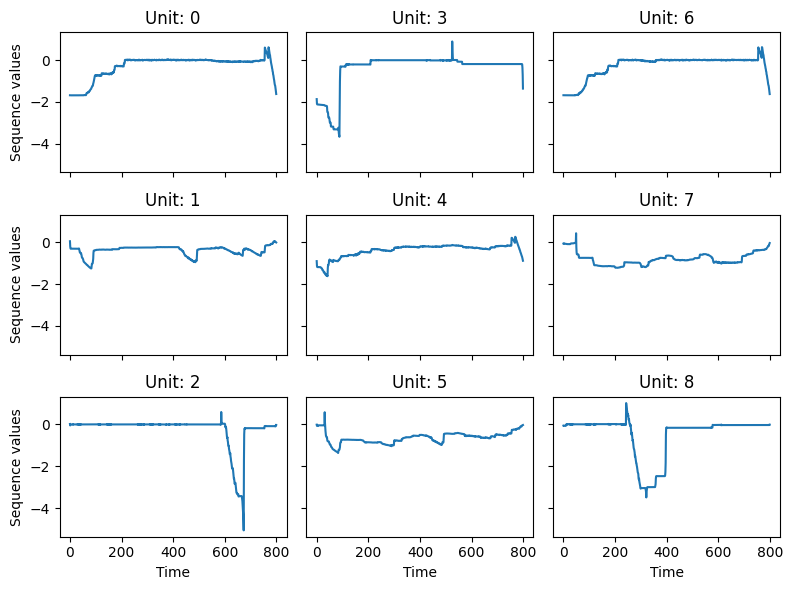

In [52]:
n_neurons = network2._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 3
    neuron_weights = network2._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

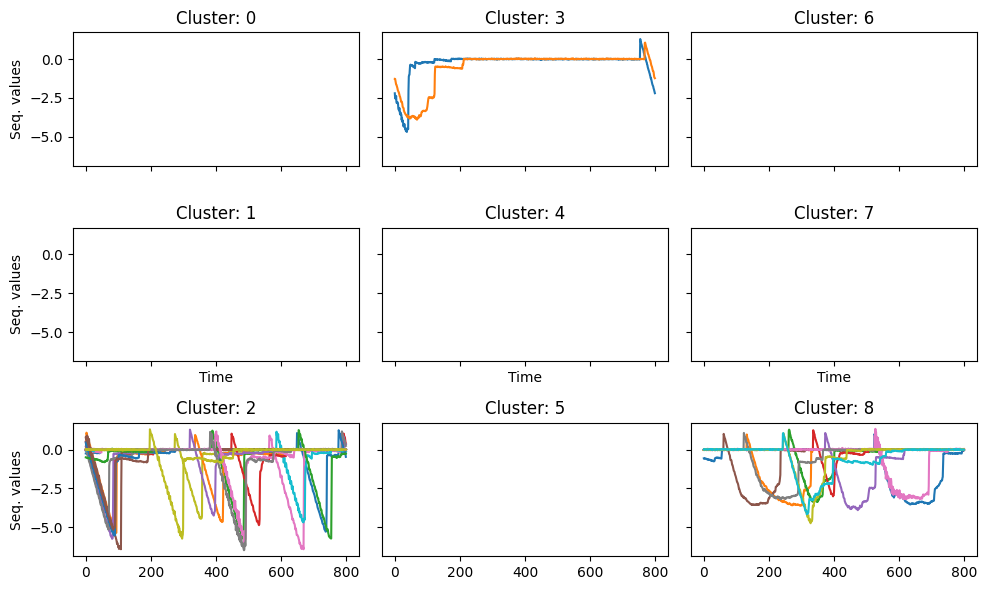

In [53]:
n = rows2
n_neurons = network2._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network2.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list2[member_index])), motif_center_list2[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

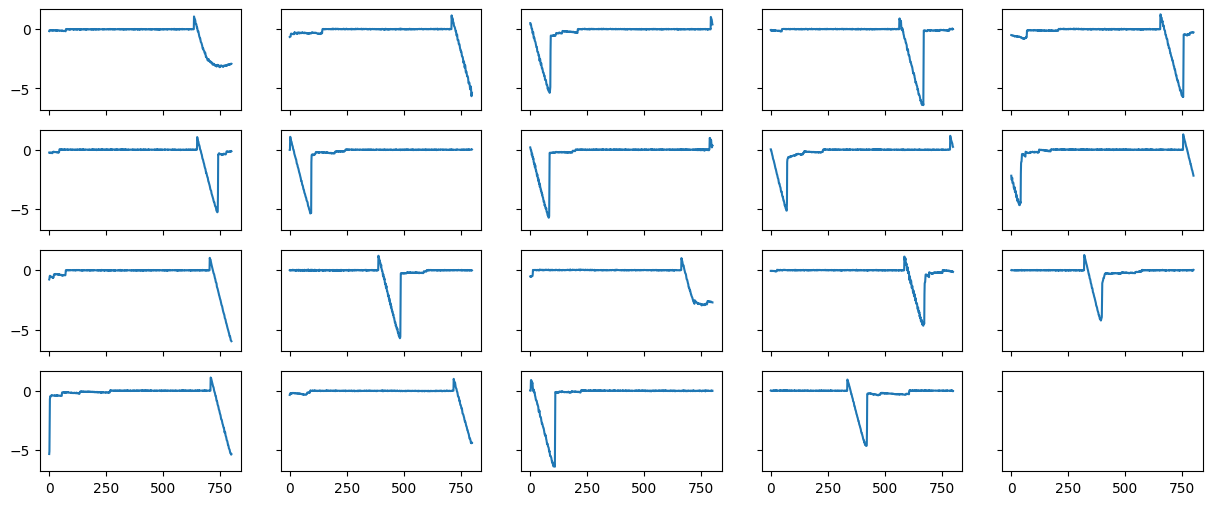

In [57]:
fig, axs = plt.subplots(4, 5,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network2.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

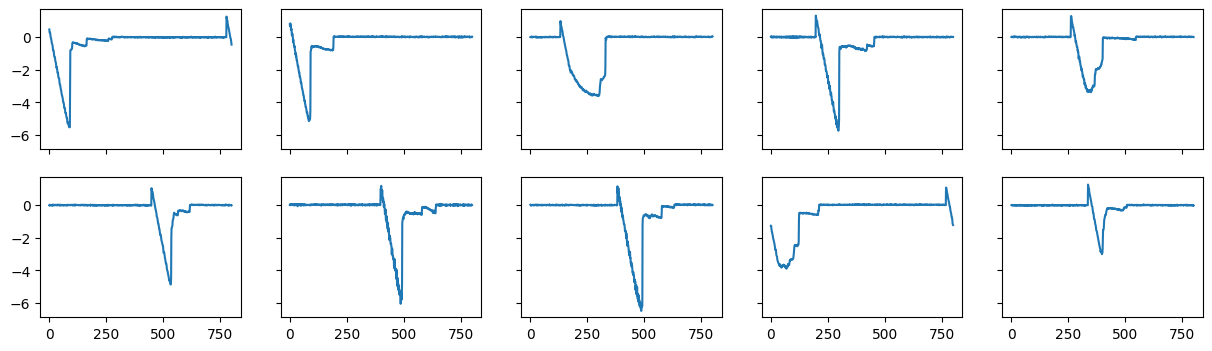

In [59]:
fig, axs = plt.subplots(2, 5,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network2.capture_objects[8]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/2)
    row = i % 2
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

### Teste 19.2 - 3x3, `grid_eight`, motifs dos clusters 2 do teste 19.1.

##### Treinando a nova rede neural

In [60]:
%%time
network.train(motif_center_list2, 50)

Epoch 1 achieved an average quantization error of 3.5855
Epoch 2 achieved an average quantization error of 4.2982
Epoch 3 achieved an average quantization error of 4.7114
Epoch 4 achieved an average quantization error of 5.0702
Epoch 5 achieved an average quantization error of 5.2658
Epoch 6 achieved an average quantization error of 5.2986
Epoch 7 achieved an average quantization error of 5.3451
Epoch 8 achieved an average quantization error of 5.3385
Epoch 9 achieved an average quantization error of 5.3115
Epoch 10 achieved an average quantization error of 5.3166
Epoch 11 achieved an average quantization error of 5.3106
Epoch 12 achieved an average quantization error of 5.283
Epoch 13 achieved an average quantization error of 5.2116
Epoch 14 achieved an average quantization error of 5.1459
Epoch 15 achieved an average quantization error of 5.0727
Epoch 16 achieved an average quantization error of 4.9537
Epoch 17 achieved an average quantization error of 4.8592
Epoch 18 achieved an ave

50

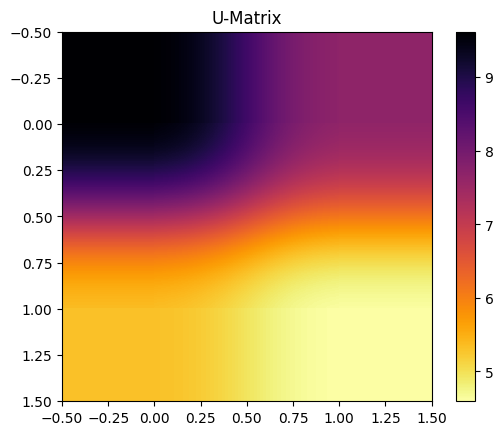

In [61]:
network.show_distance_matrix()

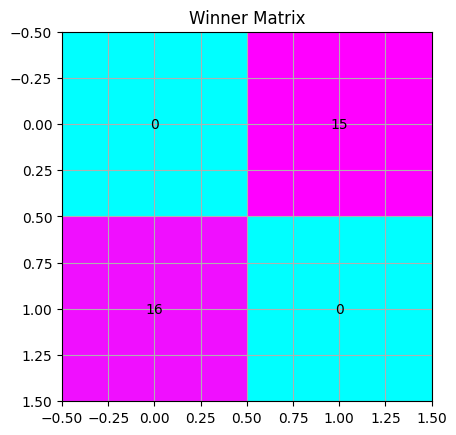

In [62]:
network.show_winner_matrix()

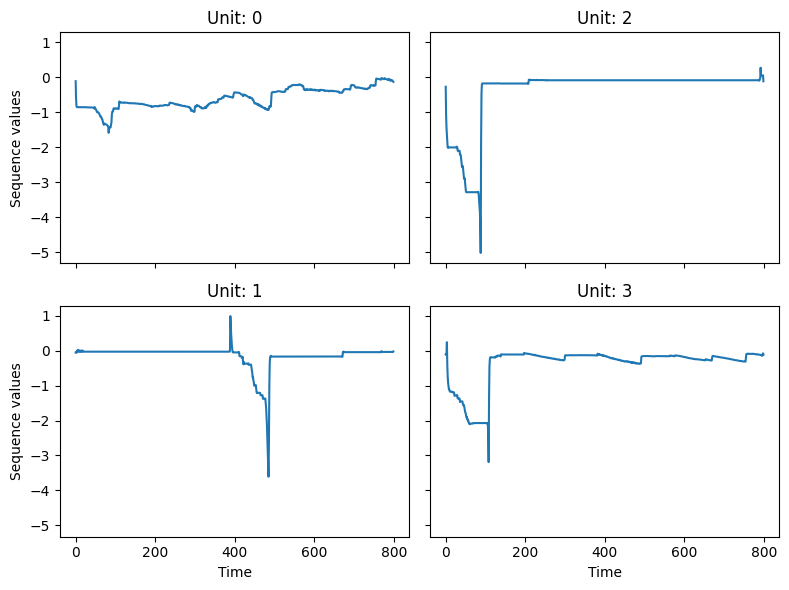

In [63]:
n_neurons = network._size
fig, axs = plt.subplots(2,2,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/2) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 2
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

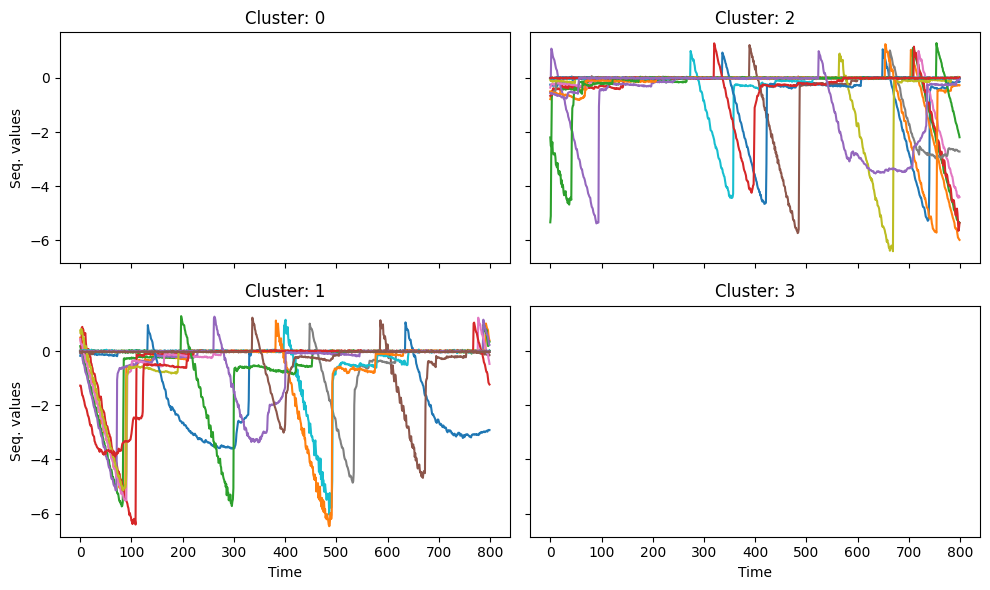

In [65]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

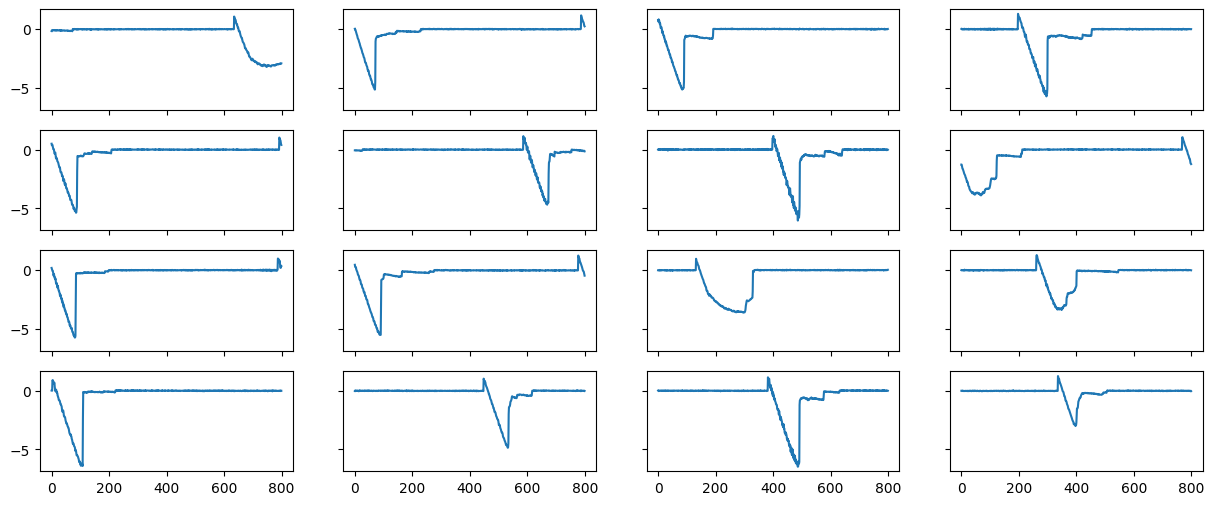

In [68]:
fig, axs = plt.subplots(4, 4,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[1]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()

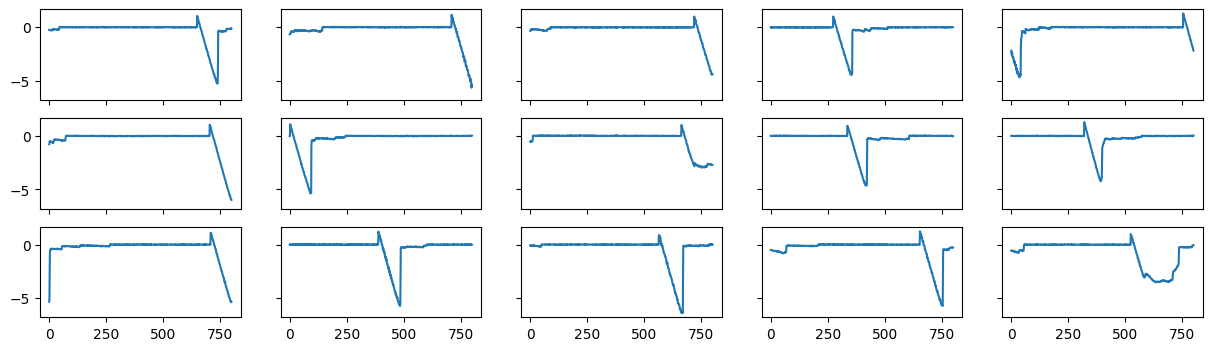

In [66]:
fig, axs = plt.subplots(3, 5,figsize=(15, 4), sharex=True, sharey=True)
cluster_list = network.capture_objects[2]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/3)
    row = i % 3
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()